In [1]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9867242361374601439\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11290777082548204524\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/6cbf0fd219fa6416ec9b47399ab16ea685b891e3-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-9867242361374601439\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Generate training data

In [2]:
Random.seed!(4);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

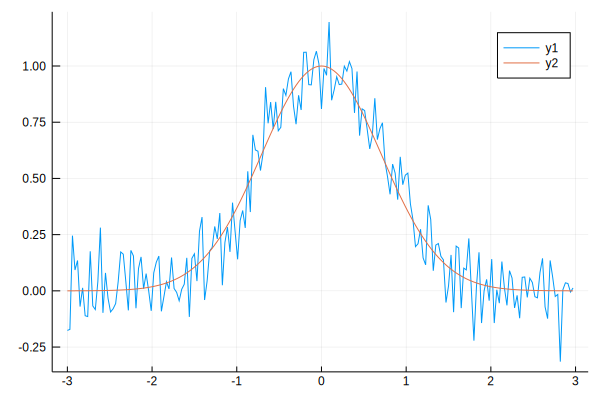

In [6]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [7]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [8]:
Nweights = 7

7

In [9]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [10]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [11]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [12]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
Random.seed!(2);
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [0.739621, -0.744507, -0.608508, -1.72346, -0.675616, 0.556646, -0.861584]


7-element Array{Float64,1}:
  0.9053831042290967 
  0.19334980578039918
  1.0568711239220563 
 -0.20774613566168482
 -0.03749308064559904
  2.5017298235041063 
 -2.734609955804095  

## Training function (with replacement)

In [13]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [14]:
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 100000; # For a quick training run
η = 0.001; # Learning rate

In [15]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

22.78240704536438

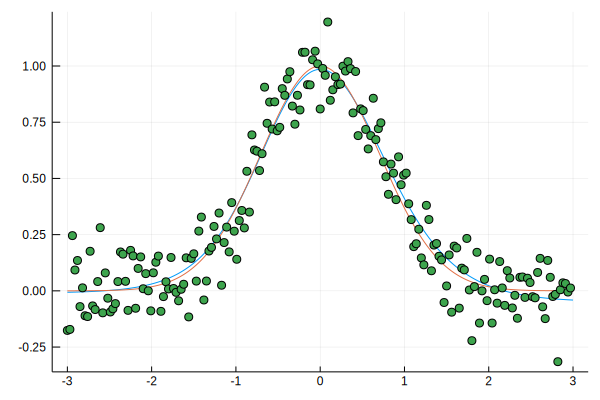

In [16]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

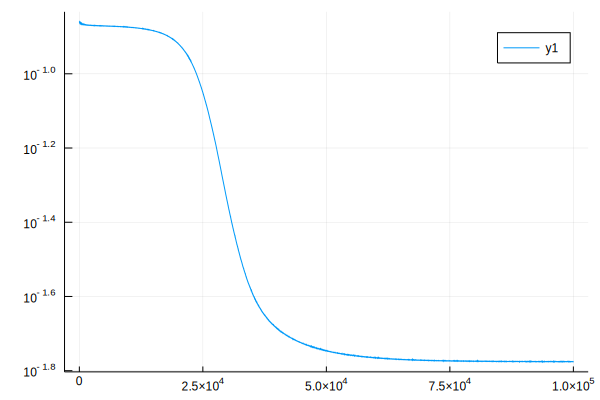

In [17]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [18]:
function diffusionmatrix(w,xt,yt,Nb,lr) # Nb = batch size
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [19]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [20]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [21]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [22]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [23]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [24]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
  1.2309808003009546 
  1.1226377819634539 
  0.6636374755671665 
 -0.6237242066102501 
  0.8857884398284767 
 -0.9024106741830754 
 -0.02678967821091651

In [25]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -1.5178830414797062e-17
  7.37257477290143e-18  
  7.589415207398531e-18 
  6.071532165918825e-18 
 -5.789639601072594e-17 
 -5.139118297581291e-17 
  1.3057859914872294e-17

### Hessian at the loss minimum

In [26]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Array{Float64,2}:
  0.152251    -0.0477188   -0.159513      0.00575416   0.188115      0.288382   -0.255211
 -0.0477188    0.191185     0.00575416    0.184902    -0.349034     -0.227777   -0.290515
 -0.159513     0.00575416   0.291827     -0.161818    -0.000504538  -0.336862    0.47856 
  0.00575416   0.184902    -0.161818      0.329763    -0.375311      0.0007127  -0.533429
  0.188115    -0.349034    -0.000504538  -0.375311     1.46174       1.15104     0.348845
  0.288382    -0.227777    -0.336862      0.0007127    1.15104       1.41088    -0.379223
 -0.255211    -0.290515     0.47856      -0.533429     0.348845     -0.379223    2.002   

In [27]:
eigvals(Hessmin), norm(Hessmin)

([2.75878, 2.53553, 0.293597, 0.192422, 0.048197, 0.00595349, 0.00516699], 3.7636935681919423)

### Diffusion tensor at the loss minimum

In [28]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Array{Float64,2}:
  1.88831e-10  -5.32896e-11  -2.04497e-10   1.99704e-11   2.25552e-10   3.63366e-10  -3.38932e-10
 -5.32896e-11   1.74339e-10   1.93927e-11   1.54906e-10  -3.50367e-10  -2.59239e-10  -2.68857e-10
 -2.04497e-10   1.93927e-11   3.28789e-10  -1.5485e-10   -5.15288e-11  -4.0503e-10    5.37777e-10
  1.99704e-11   1.54906e-10  -1.5485e-10    2.74216e-10  -3.30599e-10  -2.40275e-13  -4.98134e-10
  2.25552e-10  -3.50367e-10  -5.15288e-11  -3.30599e-10   1.59548e-9    1.35824e-9    1.39242e-10
  3.63366e-10  -2.59239e-10  -4.0503e-10   -2.40275e-13   1.35824e-9    1.65058e-9   -5.82879e-10
 -3.38932e-10  -2.68857e-10   5.37777e-10  -4.98134e-10   1.39242e-10  -5.82879e-10   2.20289e-9 

In [29]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
Dmin_num ./ Dmin

7×7 Array{Float64,2}:
 0.991519  1.0197    0.976133   0.754603  1.00563    0.983057  0.979159
 1.0197    1.00133   0.976805   1.00967   1.00678    1.00116   1.00916 
 0.976133  0.976805  0.977711   0.97474   0.905382   0.96816   0.977116
 0.754603  1.00967   0.97474    1.00224   1.02495   41.7705    0.987247
 1.00563   1.00678   0.905382   1.02495   1.00492    0.997584  1.03077 
 0.983057  1.00116   0.96816   41.7705    0.997584   0.987475  0.96846 
 0.979159  1.00916   0.977116   0.987247  1.03077    0.96846   0.996048

In [30]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [31]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Array{Float64,2}:
  9.53257e-7  -1.76395e-8  -2.7168e-7    2.00778e-8   6.42348e-8  -5.30452e-8  -1.02505e-8
 -1.76395e-8   7.17113e-7   4.36648e-8   9.69501e-8   7.20727e-8  -1.24584e-7  -5.16229e-8
 -2.7168e-7    4.36648e-8   7.84851e-7   8.52919e-8   2.28712e-7  -2.27483e-7  -1.36924e-8
  2.00778e-8   9.69501e-8   8.52919e-8   5.90928e-7  -2.09795e-7   2.04093e-7   7.07494e-9
  6.42348e-8   7.20727e-8   2.28712e-7  -2.09795e-7   8.09326e-7   3.33188e-7  -1.04931e-7
 -5.30452e-8  -1.24584e-7  -2.27483e-7   2.04093e-7   3.33188e-7   8.12191e-7  -8.25478e-8
 -1.02505e-8  -5.16229e-8  -1.36924e-8   7.07494e-9  -1.04931e-7  -8.25478e-8   1.09935e-6

In [32]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

1.4577360391569666e-20

### Derivative of the diffusion tensor

In [33]:
# construct a scalar function returning each element of the loss gradient
# sqloss is the loss without the regularization part.
function sqlossgradj(w,x,y,j)
    return sqlossgradient(w,x,y)[j]
end

sqlossgradj (generic function with 1 method)

In [34]:
# returns ∇(∂L/∂wⱼ)
sqlossgradgrad = grad(sqlossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(sqlossgradj),Int64,Bool}}) (generic function with 1 method)

In [35]:
# Calculate ∇D. ∇D[i,j,k] ≡ ∂D[j,k]/∂wᵢ

function gradkdiffij(w,xt,yt,Nb,lr)
    Nweights = length(w) 
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    ∇D = zeros(Nweights,Nweights,Nweights)
    dL = sqlossgradient(w,xt,yt)
    ddL = hessianmatrix(w,xt,yt) - 2*RegWeight*diagm(0=>ones(Nweights)) # nly sqloss()'s 2nd derivative
    for n=1:Nt
        x=xt[n]
        y=yt[n]
        
        dLn = sqlossgradient(w,[x],[y])
        
        ddLn = zeros(Nweights,Nweights);
        for i=1:Nweights
            ddLn[:,i] = sqlossgradgrad(w,[x],[y],i)
        end
        
        for i=1:Nweights
            for j=1:Nweights
                ∇D[:,i,j] += ddLn[:,i]*dLn[j] + ddLn[:,j]*dLn[i]
            end
        end
    end
    ∇D /= Nt
    
    for i=1:Nweights
        for j=1:Nweights
            ∇D[:,i,j] -= ddL[:,i]*dL[j] + dL[i]*ddL[:,j]
        end
    end

    return lr^2 * prefac * ∇D
end

gradkdiffij (generic function with 1 method)

In [36]:
# Calculate ∇D using finite difference for validation
function gradkdiffij_num(w,xt,yt,Nb,lr;eps=1e-5)
    Nw = length(w) 
    D = diffusionmatrix(w,xt,yt,Nb,lr);
    dD = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dD[i,:,:] = diffusionmatrix(w+dw,xt,yt,Nb,lr)-diffusionmatrix(w-dw,xt,yt,Nb,lr);
    end
    dD /= 2*eps
    
    return dD
end

gradkdiffij_num (generic function with 1 method)

In [37]:
# Calculate ∇[inv(D)] using finite difference for validation
function gradkinvdiffij_num(w,xt,yt,Nb,lr;eps=1e-8)
    Nw = length(w) 
    Dinv = pinv(diffusionmatrix(w,xt,yt,Nb,lr));
    dDinv = zeros(Nw,Nw,Nw);
    for i=1:Nw
        dw = zeros(Nw);
        dw[i] += eps
        dDinv[i,:,:] = pinv(diffusionmatrix(w+dw,xt,yt,Nb,lr))-pinv(diffusionmatrix(w-dw,xt,yt,Nb,lr));
    end
    dDinv /= 2*eps
    
    return dDinv
end

gradkinvdiffij_num (generic function with 1 method)

In [38]:
Random.seed!(5)
w = randn(Nweights)
@time ∇D = gradkdiffij(w,x_train,y_train,Batchsize,η);

  1.498402 seconds (2.67 M allocations: 140.764 MiB, 5.69% gc time)


norm(∇D - ∇D_num) / norm(∇D) = 0.0013823398482378988


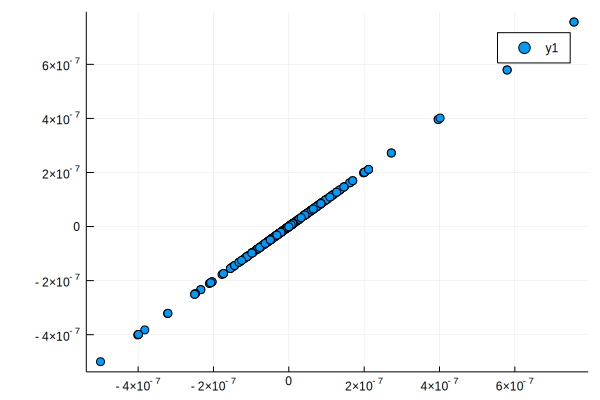

In [39]:
∇D_num = gradkdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-6);
@show norm(∇D-∇D_num)/norm(∇D)
scatter(reshape(∇D,Nweights^3,1),reshape(∇D_num,Nweights^3,1))

In [40]:
D = diffusionmatrix(w,x_train,y_train,Batchsize,η)
invD = pinv(D)
∇invD = zeros(Nweights,Nweights,Nweights)
for n=1:Nweights
    ∇invD[n,:,:] = -invD*∇D_num[n,:,:]*invD # = ∂D⁻¹/∂w_n # this works
#    ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD # = ∂D⁻¹/∂w_n # this doesn't, although ∇D and ∇D_num agree to within 0.1%
end
∇invD_num = gradkinvdiffij_num(w,x_train,y_train,Batchsize,η,eps=1e-8);
norm(∇invD-∇invD_num)/norm(∇invD)

0.037072950132560824

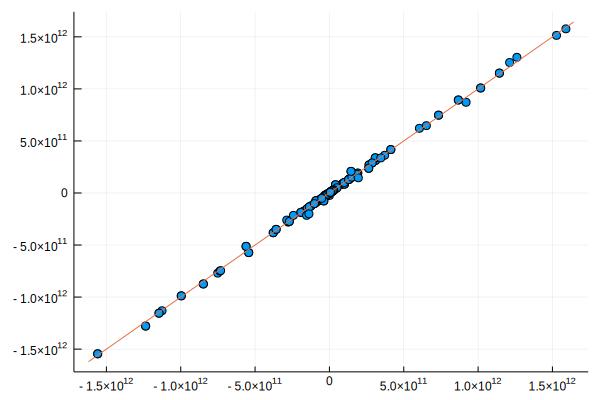

In [41]:
# What is the problem with ∇invD[n,:,:] = -invD*∇D[n,:,:]*invD in the previous cell?
scatter(reshape(∇invD,Nweights^3,1),reshape(∇invD_num,Nweights^3,1))
g(x)=x
plot!(g,leg=false)

In [42]:
@show Temp = 0.1*norm(Dmin)/η
invD = pinv(Dmin)
C = η*Temp*invD
eigvals(C)

Temp = (0.1 * norm(Dmin)) / η = 4.208736930004842e-7


7-element Array{Float64,1}:
 2985.320948885626     
  119.3920233269861    
   10.41677465770509   
    2.3559472974169693 
    1.340922140374134  
    0.12645025622346032
    0.1650380516635974 

## Thermal SGD - with C = lr\*T\*inv(Dmin)

In [43]:
function thermaltrain!(w,lr)
    perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
    x = [x_train[n] for n in perm]
    y = [y_train[n] for n in perm]
# gradient calculated on the batch
    gradw = lossgradient(w,x,y);
#update    
    dw = C*gradw # + q, but q=0
# update weights
#    w .-= lr*dw
for i=1:length(w)
    w[i] -= lr*dw[i]
end
    
return w
end

thermaltrain! (generic function with 1 method)

## Steady state

In [44]:
Random.seed!(2) # Verified that the results don't change for different seeds.
Nmarkov = 10^7;

In [45]:
w = copy(wmin); # start from the minimum of the potential

In [46]:
fname = "Gaussian-thermal-$Nmarkov-$η-$Temp.jld2"
w_ss = zeros(Nweights,Nmarkov)
if !isfile(fname)
    time0 = time() # takes about an hour for Nmarkov = 10^7
    for n = 1:Nmarkov
        w_ss[:,n] = thermaltrain!(w,η)
    end
    @show time()-time0
    Knet.save(fname, "w_ss", w_ss)
    else
        w_ss = Knet.load(fname, "w_ss");
    end
@show summary(w_ss)

summary(w_ss) = "7×10000000 Array{Float64,2}"


"7×10000000 Array{Float64,2}"

In [47]:
Nhist=10^5
skip = div(Nmarkov,Nhist)
trajloss = zeros(Nhist) 
for n=1:Nhist
    trajloss[n] = loss(w_ss[:,n*skip],x_train,y_train)
end

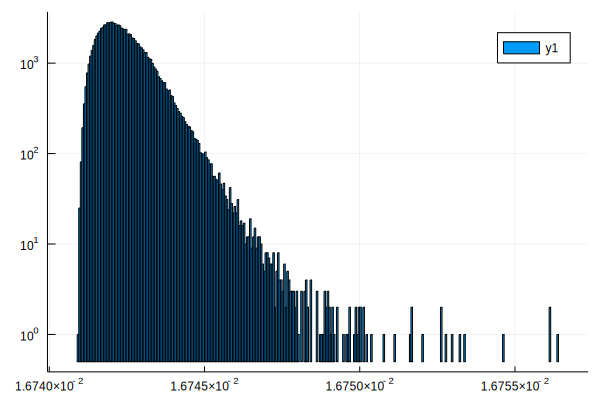

In [48]:
histogram(trajloss
    ,yaxis=:log
)
#histogram(w_ss[1,:])

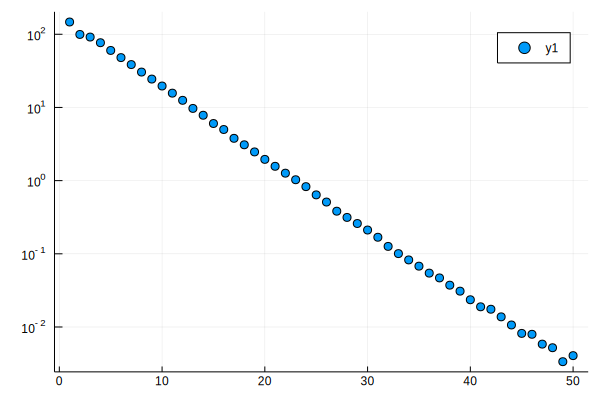

In [49]:
fith = fit(Histogram,trajloss,nbins=200)
my_y = fith.weights # bin counts
my_x = collect(1:length(my_y))
y = my_y[1:end] ./ ((my_x.-0.5)[1:end].^2.5)
y .+= 1e-10
scatter(y[1:50],yaxis=:log)

### Fit a Mv-Gaussian to the equilibrium data

In [50]:
Fit_ss = fit_mle(MvNormal,w_ss)

FullNormal(
dim: 7
μ: [1.231, 1.12277, 0.66368, -0.62379, 0.885818, -0.902422, -0.0268137]
Σ: [2.67083e-5 -8.41814e-6 … 8.42538e-6 1.22709e-6; -8.41814e-6 2.54032e-5 … 1.16102e-5 1.42562e-6; … ; 8.42538e-6 1.16102e-5 … 2.65075e-5 8.78714e-7; 1.22709e-6 1.42562e-6 … 8.78714e-7 7.07495e-7]
)


### Steady-state mean


In [51]:
w_mean = Fit_ss.μ

7-element Array{Float64,1}:
  1.2309987587140039  
  1.1227731583376455  
  0.6636799443607629  
 -0.6237902674187369  
  0.885817658973149   
 -0.9024219728926712  
 -0.026813663238012108

In [52]:
norm(w_mean-wmin)/norm(wmin)

7.118431944058679e-5

### Covariance matrix (from ss-trajectory)

In [53]:
Cov_ss = Distributions.cov(Fit_ss)

7×7 Array{Float64,2}:
  2.67083e-5  -8.41814e-6   2.63987e-5   7.08668e-6  -1.05774e-5   8.42538e-6   1.22709e-6
 -8.41814e-6   2.54032e-5  -8.47327e-6  -2.63722e-5  -9.07601e-6   1.16102e-5   1.42562e-6
  2.63987e-5  -8.47327e-6   3.74586e-5  -1.22284e-6  -2.12381e-5   1.95593e-5   2.49762e-7
  7.08668e-6  -2.63722e-5  -1.22284e-6   4.13522e-5   2.33362e-5  -2.52332e-5  -4.72471e-7
 -1.05774e-5  -9.07601e-6  -2.12381e-5   2.33362e-5   2.60109e-5  -2.58637e-5  -8.05486e-7
  8.42538e-6   1.16102e-5   1.95593e-5  -2.52332e-5  -2.58637e-5   2.65075e-5   8.78714e-7
  1.22709e-6   1.42562e-6   2.49762e-7  -4.72471e-7  -8.05486e-7   8.78714e-7   7.07495e-7

## Test thermalization: Σ⁻¹ vs H

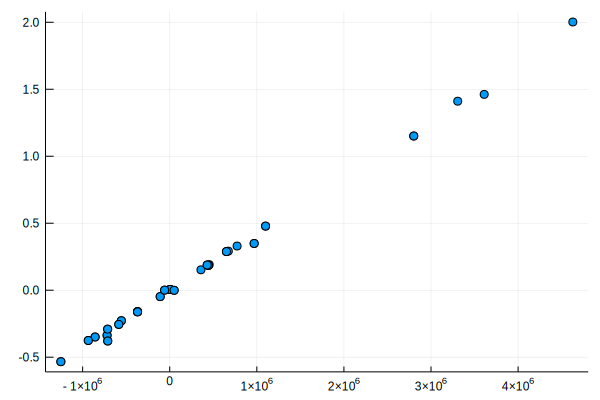

In [54]:
# Check if inv(Σ) ∝ H
scatter(reshape(inv(Cov_ss),Nweights^2,1),reshape(Hessmin,Nweights^2,1),leg=false)

### Visualize the steady-state distribution

In [55]:
# weight indices to visualize
xid,yid = Nweights,Nweights-1

(7, 6)

In [56]:
ss_range=collect(1:Nmarkov) # may want to leave out a transient 
wx = w_ss[xid,ss_range]
wy = w_ss[yid,ss_range]
resxy=(200,200) # histogram bins

# Extract histogram data
fith = fit(Histogram,(wx,wy),nbins=resxy)
fith.weights # bin counts
fith.edges # bin boundaries
maxhist=maximum(fith.weights); # will use later for better looking plots

In [57]:
# Construct a grid enclosing the steady-state trajectory
minmaxdiff(t) = maximum(t)-minimum(t)

function makegrid(xvec,yvec,mean,xindex,yindex;Nx=50,Ny=50,zoom=0.7)
    Lx,Ly = minmaxdiff(xvec)/2.0,minmaxdiff(yvec)/2.0
    xrange,yrange = zoom*Lx,zoom*Ly
    dx,dy = xrange/Nx,yrange/Ny
    x = collect(-xrange:dx:xrange) .+ mean[xindex]
    y = collect(-yrange:dy:yrange) .+ mean[yindex]

    # some mumbo-jumbo for calculating weights corresponding to grid points
    Identity = Diagonal(ones(Nweights,Nweights)); # unit matrix
    xmask = Identity[:,xindex];
    ymask = Identity[:,yindex];
    Imask = Identity - xmask*xmask' - ymask*ymask' # set two diagonal elements to zero
    return (x,y,Imask,xmask,ymask,[x[1],x[end]],[y[1],y[end]])
end

(x,y,Imask,xmask,ymask,xrange,yrange) = makegrid(wx,wy,w_mean,xid,yid);

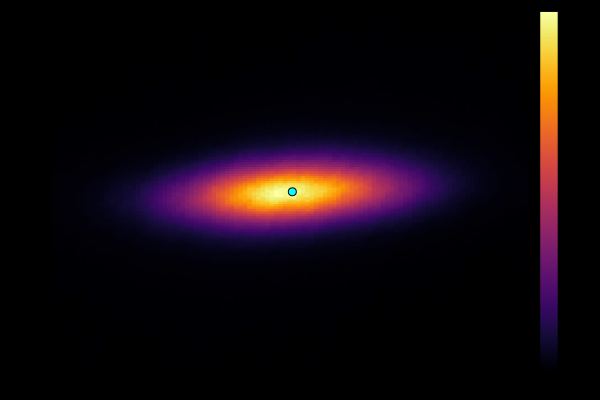

In [58]:
histogram2d(wx,wy
    ,bins=resxy
    ,xlim=xrange
    ,ylim=yrange
)
scatter!([wmin[xid]],[wmin[yid]]
#    ,aspect_ratio=1.0
    ,leg=false # no legend
    ,markercolor="cyan"
    ,markersize=4
    ,background_color="black"
    ) # loss minimum

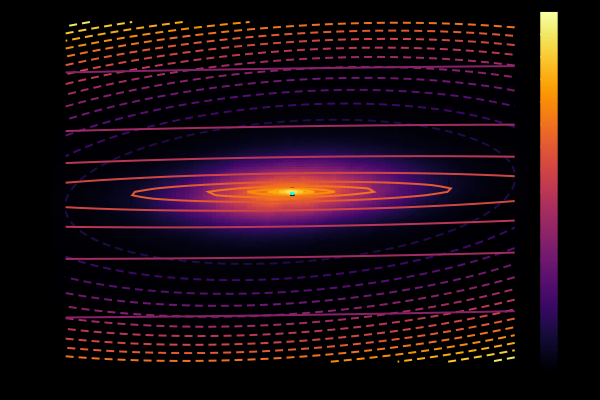

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [59]:
# overlay loss and isoprobability contours

meanxy = w_mean[[xid yid]]

# 2x2 submatrix corresponding to the inverse covariance for the marginal distribution p(xid,yid)
Cov_xy_inv = inv(Cov_ss[[xid,yid],[xid,yid]])

## mv-Gaussian fit contours
fexp(s,t) = -(([s t]-meanxy)*Cov_xy_inv*([s t]-meanxy)')[1]
ffit(s,t) =  maxhist * fexp(s,t)/fexp(x[end],y[end])
contour!(x,y,ffit # "!" draws on top of the previous plot
    ,linestyle=:dash
    ,linewidth=2)

## Loss contours
midx = Int((length(x)-1)/2)
midy = Int((length(y)-1)/2)
fexp(s,t) = loss(Imask*w_mean + s*xmask + t*ymask,x_train,y_train) - loss(wmin,x_train,y_train)
flossxy(s,t) = maxhist * log(fexp(s,t))/log(fexp(x[midx],y[midy]))
contour!(x,y,flossxy,linewidth=2)

### Move to the eigen-coordinates

In [60]:
# pick two eigen directions
Xid,Yid = Nweights,Nweights-1
O = eigvecs(Cov_ss);
Λ = eigvals(Cov_ss);

W_ss = O'*w_ss; # sample weights are row vectors
Wx = W_ss[Xid,:]
Wy = W_ss[Yid,:]

COV_ss = O'*Cov_ss*O # by construction diagonal
COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]]) # this must be Diag(λx,λy)

Wmean = O'*w_mean
Wmin = O'*wmin;

In [61]:
# COV_xy_inv = Diag(λx,λy)
norm(COV_xy_inv - Diagonal([1/Λ[Xid],1/Λ[Yid]]))

9.302000671474615e-12

### Visualize in the eigenspace

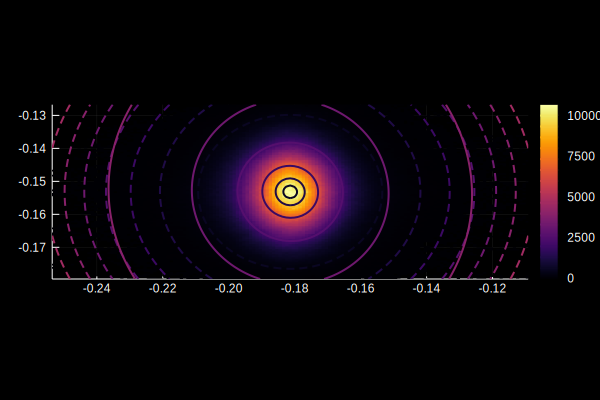

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [62]:
(x,y,Imask,xmask,ymask,xrange,yrange) = makegrid(Wx,Wy,Wmin,Xid,Yid;Nx=60,Ny=60)
histogram2d(Wx,Wy
    ,bins=resxy
    ,aspect_ratio=1
    ,background_color="black"
    ,xlim=xrange
    ,ylim=yrange
)

meanXY = Wmin[[Xid Yid]]
# Contours of the fit mv-Gaussian
fexp(s,t) = -(([s t]-meanXY)*COV_xy_inv*([s t]-meanXY)')[1]
Ffit(s,t) = (maxhist/2)* fexp(s,t)/fexp(x[end],y[end])
contour!(x,y,Ffit,
    linestyle=:dash,
#     levels=75,
    linewidth=2)

# contours of loss
midx = Int((length(x)-1)/2)
midy = Int((length(y)-1)/2)
fexp(s,t) = loss(O*(Imask*Wmin + s*xmask + t*ymask),x_train,y_train) - loss(wmin,x_train,y_train)
Flossxy(s,t) =  (maxhist/20)*log((fexp(s,t)/fexp(x[midx],y[midy]))+1)
contour!(x,y,Flossxy,
    linewidth=2)

## Rotation

In [63]:
function arealvelocity(traj,x,y,center)
    N = length(traj[1,:]) # trajectory length
    Area=zeros(N-1);
    Areasum=0
    for n=1:N-1
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        v2=[traj[x,n+1]-center[x],traj[y,n+1]-center[y],0]
        Areasum += cross(v1,v2)[3] # this is twice the area of the triangle
    end
    return Areasum/(2*(N-1))
end


arealvelocity (generic function with 1 method)

In [64]:
fname = "Gaussian-thermal_arealvelocity_$Nmarkov.jld2"
if !isfile(fname)
    Av = zeros(Nweights,Nweights)
    time0 = time() # takes about 11 minutes for Nmarkov = 10^7
    for i = 1:Nweights-1
        for j = i+1:Nweights # av is antisymmetric
            Av[i,j] = arealvelocity(W_ss,i,j,Wmean)
            Av[j,i] = -Av[i,j]
        end
    end
    Av /= η^2
    @show time()-time0
    
    Knet.save(fname, "Av", Av)
else
    Av = Knet.load(fname, "Av");
end

7×7 Array{Float64,2}:
  0.0          1.20014e-7   8.36365e-7    1.14209e-6   -2.86854e-6    4.6689e-6     6.74357e-6 
 -1.20014e-7   0.0         -9.00274e-7    1.51818e-6   -1.49618e-5   -3.26407e-5    2.33578e-5 
 -8.36365e-7   9.00274e-7   0.0          -1.65331e-5   -2.99561e-5    3.97552e-5    0.000211715
 -1.14209e-6  -1.51818e-6   1.65331e-5    0.0           2.43136e-5   -0.000116068   9.95844e-6 
  2.86854e-6   1.49618e-5   2.99561e-5   -2.43136e-5    0.0          -0.000218495  -0.00138535 
 -4.6689e-6    3.26407e-5  -3.97552e-5    0.000116068   0.000218495   0.0          -0.00106243 
 -6.74357e-6  -2.33578e-5  -0.000211715  -9.95844e-6    0.00138535    0.00106243    0.0        

In [65]:
# (HΣ-ΣH)/2η may be better than (ηHΣ-D)/η² numerically,
# since it is antisymmetric by construction.
# Alternatively, once can substitute Σ(H₀,D₀), solution of the Lyapunov equation, for Σ
# if the values of H and D are more reliable.

#Av_theo = O'*(η*Hessmin*Covmin - Dmin)*O/η^2
Av_theo = O'*(η/2)*(Hessmin*Cov_ss - Cov_ss*Hessmin)*O/η^2

7×7 Array{Float64,2}:
 -2.41432e-19   7.36882e-7    7.11985e-6    2.15593e-5   -5.39918e-7   -6.22804e-5    4.52313e-5 
 -7.36882e-7   -1.32462e-19   2.9912e-6    -5.52611e-6   -4.62376e-5    5.9057e-6    -9.72724e-6 
 -7.11985e-6   -2.9912e-6     2.20394e-18  -4.30956e-7    4.53703e-6    2.48353e-5   -1.76889e-5 
 -2.15593e-5    5.52611e-6    4.30956e-7   -6.84152e-20  -9.1724e-6     3.64015e-5   -9.07547e-7 
  5.39918e-7    4.62376e-5   -4.53703e-6    9.1724e-6     4.38692e-19  -3.54356e-6   -4.12039e-6 
  6.22804e-5   -5.9057e-6    -2.48353e-5   -3.64015e-5    3.54356e-6    2.47714e-20   1.51833e-6 
 -4.52313e-5    9.72724e-6    1.76889e-5    9.07547e-7    4.12039e-6   -1.51833e-6    1.29041e-19

In [66]:
@show 2*norm(Av-Av_theo)/(norm(Av)+norm(Av_theo))
@show std(Av), std(Av_theo), std(Av-Av_theo);

(2 * norm(Av - Av_theo)) / (norm(Av) + norm(Av_theo)) = 1.8925122765739768
(std(Av), std(Av_theo), std(Av - Av_theo)) = (0.0003628216096792881, 2.15447900214003e-5, 0.00036370906506804653)


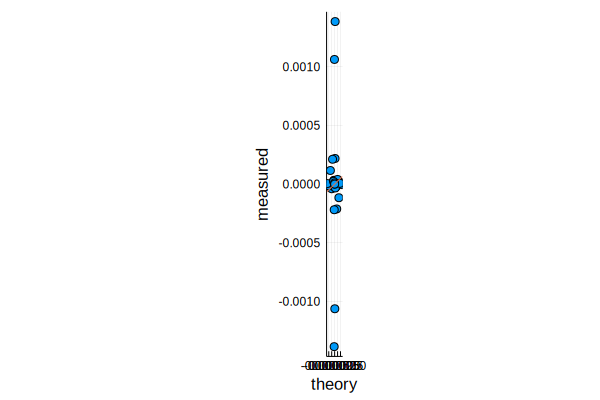

In [67]:
# Compare theory vs numerics for the areal velocity on each eigen-plane.
scatter(reshape(Av_theo,Nweights^2,1),reshape(Av,Nweights^2,1)
    ,leg=:false
    ,aspect_ratio=1.0
)
g(x)=x
plot!(g
    ,xlabel="theory"
    ,ylabel="measured")

In [68]:
# monitor the area swept during rotation
function area_vs_t(traj,x,y,center)
    N = length(traj[1,:])
    Area=zeros(N);
    Areasum=zeros(N);
    rad=0; # mean radius of the trajectory
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n-1]-center[x],traj[y,n-1]-center[y],0]
        v2=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        rad += norm(v2)
        # get the angle between them. Sign of Sinθ gives the direction
        Area[n] = cross(v1,v2)[3]/2
        Areasum[n] = Areasum[n-1]+Area[n]
    end
    
    return Areasum,rad/(N-1)
end

area_vs_t (generic function with 1 method)

In [69]:
#areaX = Nweights
#areaY = Nweights-1
# Look at the eigen-plane with maximal areal velocity
# or uncomment above to choose your own

@show areaX,areaY = Tuple(findmax(Av)[2])
rad = zeros(Nweights,Nweights); # mean radius of w projections for each eigenvector pair

(areaX, areaY) = Tuple((findmax(Av))[2]) = (7, 5)


In [70]:
area_sample_rate=10
@time area,rad[areaX,areaY] = area_vs_t(W_ss[:,1:area_sample_rate:end],areaX,areaY,Wmean);

  3.751070 seconds (15.23 M allocations: 682.893 MiB, 12.57% gc time)


In [71]:
np = length(area)
plot_sample_rate = div(np,1000)
x = plot_sample_rate*area_sample_rate*collect(1:1000);
orbit_area = π*rad[areaX,areaY]^2

0.00022650002964728943

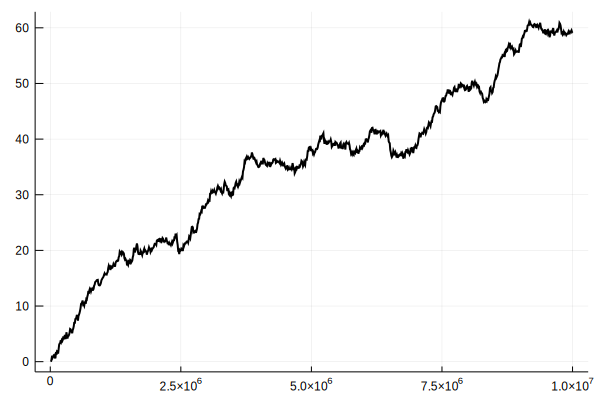

In [72]:
plot(x,area[1:plot_sample_rate:end]/orbit_area,leg=false,linewidth=2,linecolor="black")

### Rotation analysis by Fourier transform

In [73]:
using FFTW

In [74]:
Wfft = fft(W_ss[end,:])

10000000-element Array{Complex{Float64},1}:
 -1.8143335711000727e6 + 0.0im               
   -40.719802202812225 + 101.10872822203383im
    -86.07943836904225 - 251.00264239898178im
    -256.8785808319019 + 144.18318744037im   
     77.49855895072572 + 268.4879839919395im 
     23.43239137368194 + 206.3815127326817im 
    -320.6156453223042 + 492.97596124548545im
    222.63767891783004 + 546.3179579793745im 
     73.90736973688689 - 223.9685847522494im 
   -358.13887682413986 + 193.81197579297034im
   -34.457796124640765 - 143.29365741319177im
     41.94096278726036 - 239.7481023107915im 
    -597.2273286461436 - 724.8775115770488im 
                       ⋮                     
    -597.2273286461436 + 724.8775115770487im 
     41.94096278726041 + 239.7481023107914im 
   -34.457796124640794 + 143.2936574131918im 
   -358.13887682413986 - 193.8119757929704im 
     73.90736973688685 + 223.9685847522493im 
    222.63767891783004 - 546.3179579793743im 
    -320.6156453223041 - 492.9759612

In [75]:
scatter(abs.(real(Wfft[2:1000:end-1]))
    ,yaxis=:log
    ,markersize=0.2
)

In [76]:
# compare with the FFT of a random signal
myss = randn(length(W_ss[end,:])); myfft = fft(myss);
scatter(abs.(real(myfft[1:1000:end]))
    ,yaxis=:log
    ,markersize=0.2
)

In [84]:
function angulardisp(traj,x,y,center)
    N = length(traj[1,:]) # trajectory length
    angle=0
    for n=1:N-1
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        v2=[traj[x,n+1]-center[x],traj[y,n+1]-center[y],0]
        angle += asin(cross(v1,v2)[3]/(norm(v1)*norm(v2))) # this is twice the area of the triangle
    end
    return angle
end


Ad = zeros(Nweights,Nweights) # angular displacement
time0 = time() # takes about 11 minutes for Nmarkov = 10^7
for i = 1:Nweights-1
    for j = i+1:Nweights # av is antisymmetric
        Ad[i,j] = angulardisp(W_ss,i,j,Wmean)
        Ad[j,i] = -Ad[i,j]
        end
end
@show time()-time0
Ad

time() - time0 = 714.6692199707031


7×7 Array{Float64,2}:
   0.0     -125.048     14.1398  -191.201    82.8407    -66.2327  -301.643
 125.048      0.0       88.4211   135.256    -6.18089    34.2      179.233
 -14.1398   -88.4211     0.0     -398.136  -160.084     -57.2066  -389.555
 191.201   -135.256    398.136      0.0     422.452    -124.214    620.553
 -82.8407     6.18089  160.084   -422.452     0.0      -436.197   -800.698
  66.2327   -34.2       57.2066   124.214   436.197       0.0     -269.519
 301.643   -179.233    389.555   -620.553   800.698     269.519      0.0  

In [85]:
Ad/2π

7×7 Array{Float64,2}:
   0.0      -19.9019    2.25042  -30.4306   13.1845   -10.5413    -48.008 
  19.9019     0.0      14.0727    21.5266   -0.98372    5.44309    28.5259
  -2.25042  -14.0727    0.0      -63.3652  -25.4781    -9.10471   -61.9996
  30.4306   -21.5266   63.3652     0.0      67.2353   -19.7692     98.764 
 -13.1845     0.98372  25.4781   -67.2353    0.0      -69.4228   -127.435 
  10.5413    -5.44309   9.10471   19.7692   69.4228     0.0       -42.8952
  48.008    -28.5259   61.9996   -98.764   127.435     42.8952      0.0   

In [87]:
norm(Ad/2π)

321.1814242130372

In [92]:
eigvals(Ad/2π)

7-element Array{Complex{Float64},1}:
 -7.105427357601002e-15 + 212.00501976666786im
 -7.105427357601002e-15 - 212.00501976666786im
 1.7763568394002505e-15 + 78.58967973485241im 
 1.7763568394002505e-15 - 78.58967973485241im 
  4.820424231328687e-15 + 0.0im               
 1.7763568394002505e-15 + 21.36088627996515im 
 1.7763568394002505e-15 - 21.36088627996515im 